<a href="https://colab.research.google.com/github/IGPTsewwandi/Image-Processing-Based-Smart-Waste-Management-System-/blob/feature%2Fclassification/waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Change this path according to where your dataset is stored in Drive
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Dataset_Split"

train_dir = dataset_path + "/Train"
test_dir  = dataset_path + "/Test"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [5]:
# Data Augmentation
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_classes = len(train_gen.class_indices)
class_labels = list(train_gen.class_indices.keys())
print("Classes:", class_labels)


Found 10068 images belonging to 5 classes.
Found 1565 images belonging to 5 classes.
Classes: ['Glass', 'Metal', 'Organic', 'Paper', 'Plastic']


In [6]:
# Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,181 (12.61 MB)

 Trainable params: 3,305,733 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
# Train Model
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 2940s 9s/step - accuracy: 0.2049 - loss: 4.0386 - val_accuracy: 0.1923 - val_loss: 5.4931
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - accuracy: 0.2013 - loss: 1.6324 - val_accuracy: 0.2211 - val_loss: 1.6038
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.2042 - loss: 1.6110 - val_accuracy: 0.1419 - val_loss: 1.6082
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.1988 - loss: 1.6096 - val_accuracy: 0.2179 - val_loss: 1.6050
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.2012 - loss: 1.6103 - val_accuracy: 0.2792 - val_loss: 1.6067
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.1986 - loss: 1.6099 - val_accuracy: 0.2805 - val_loss: 1.6050
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.2050 - loss: 1.6095 - val_accuracy: 0.2805 - val_loss: 1.6053
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.1906 - loss: 1.6095 - val_acc

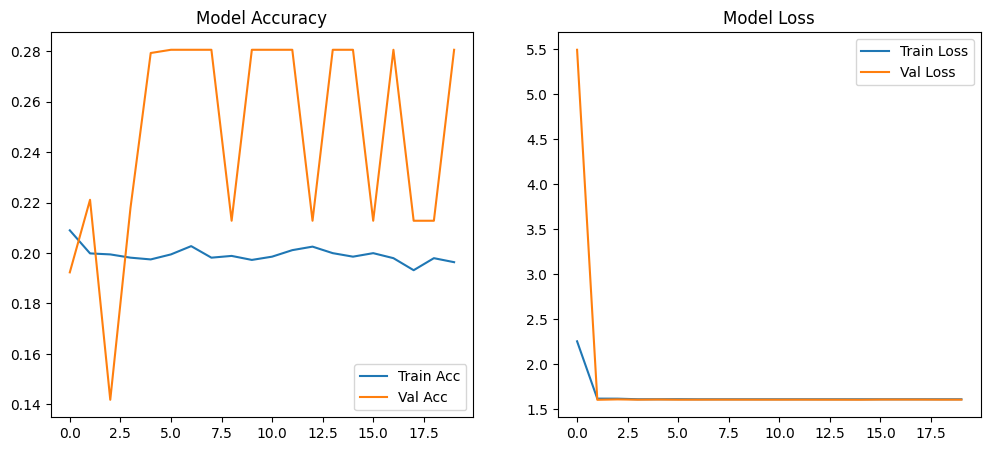

In [8]:
# Plot Accuracy & Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 377ms/step - accuracy: 0.1445 - loss: 1.6053

 Test Accuracy: 28.05%
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 377ms/step

 Classification Report:

              precision    recall  f1-score   support

       Glass       0.00      0.00      0.00       333
       Metal       0.00      0.00      0.00       189
     Organic       0.00      0.00      0.00       222
       Paper       0.28      1.00      0.44       439
     Plastic       0.00      0.00      0.00       382

    accuracy                           0.28      1565
   macro avg       0.06      0.20      0.09      1565
weighted avg       0.08      0.28      0.12      1565



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


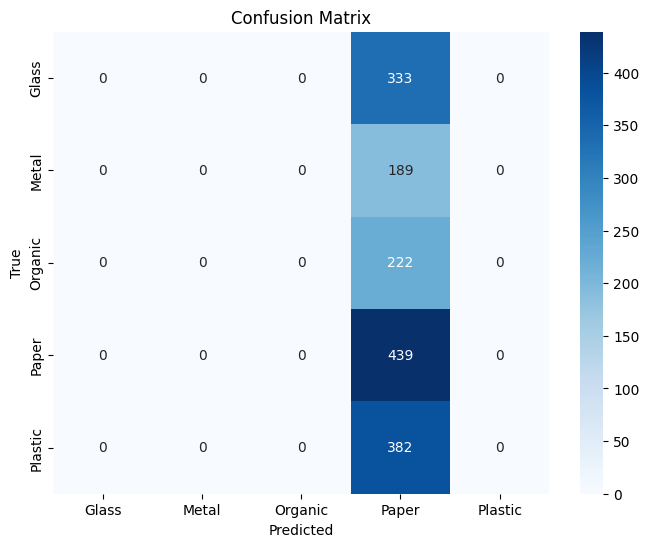

In [9]:
# Evaluate Model
loss, acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("\n Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [11]:
# Statistical Report
counts = Counter(y_pred_classes)
report_data = {class_labels[k]: v for k,v in counts.items()}

df_report = pd.DataFrame(list(report_data.items()), columns=["Category", "Count"])
print("\n Waste Classification Report:\n")
print(df_report)

# Save outputs in Drive
output_path = "/content/drive/MyDrive/waste_outputs"
os.makedirs(output_path, exist_ok=True)

df_report.to_csv(os.path.join(output_path, "waste_classification_report.csv"), index=False)
model.save(os.path.join(output_path, "waste_classifier_model.h5"))

print(f"\n Model & Report saved in {output_path}")



 Waste Classification Report:

  Category  Count
0    Paper   1565

 Model & Report saved in /content/drive/MyDrive/waste_outputs
